In [114]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import os
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.simplefilter('always', category=UserWarning)
print(tf.__version__)

2.8.4


### Becoming one with the data

I'll use the dataset ECG5000 with 7600 rows for training and 1900 for testing.
Each row contains a cardiac cicle with 140 values and it can belong to 5 categories:

1. Normal
2. Abnormal: premature ventricular contraction
3. Abnormal: premature supraventricular contraction
4. Abnormal: ectopic beat
5. Abnormal but unknown pathology

In [83]:
train = pd.read_csv("./ECG5000_train.csv")
test = pd.read_csv("./ECG5000_test.csv")
train.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1,-1.30300,-0.83573,-1.9336,-2.09420,-2.02840,-1.2531,-0.52638,-0.089286,-0.07557,...,-1.45820,-1.6676,-1.5977,-1.67930,-1.677200,-1.69370,-1.79410,-1.35940,-2.08120,-2.82880
1,2,0.32288,-0.87847,-1.8023,-2.66850,-3.26550,-3.3326,-2.88000,-2.227400,-1.54360,...,-1.23050,-1.7218,-2.1953,-2.74890,-3.446500,-3.66210,-3.01820,-1.65140,-0.23670,0.82832
2,2,1.39340,1.59260,1.2420,0.79449,0.19577,-0.3156,-0.58053,-0.945020,-1.23350,...,-1.90850,-2.5295,-3.0614,-3.50370,-3.900400,-4.24600,-4.13380,-3.19850,-2.42200,-1.07370
3,1,-3.52270,-5.02610,-4.3613,-4.10570,-3.10420,-1.8178,-1.39840,-1.070100,-0.40691,...,0.83038,1.0084,1.1830,0.94636,0.952130,0.79343,0.84741,1.01390,0.31234,-2.19060
4,1,-1.91820,-3.22510,-3.4652,-4.00800,-3.87030,-3.3581,-2.28540,-1.728500,-1.42220,...,1.77690,1.5029,1.1651,0.46073,0.019172,-0.32739,-0.48051,-0.18814,0.14284,-0.66844


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Columns: 141 entries, 0 to 140
dtypes: float64(140), int64(1)
memory usage: 8.2 MB


In [4]:
# Check for null values
train.isna().sum().value_counts()

0    141
Name: count, dtype: int64

In [5]:
train.rename(columns={"0": "label"}, inplace=True)

In [6]:
train["label"].value_counts()

label
1    4427
2    2683
4     306
3     149
5      35
Name: count, dtype: int64

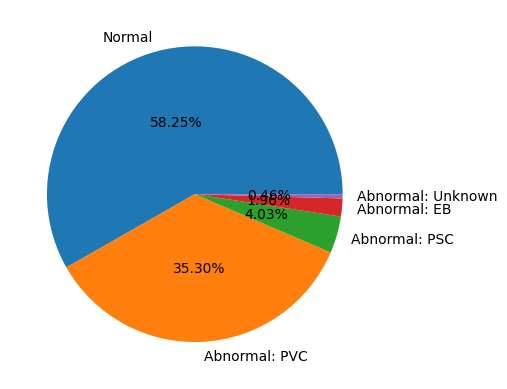

In [7]:
plt.figure()
train["label"].value_counts()
plt.pie(train["label"].value_counts(), autopct="%1.2f%%", pctdistance=0.5, labeldistance=1.1, labels=["Normal", "Abnormal: PVC", "Abnormal: PSC", "Abnormal: EB", "Abnormal: Unknown"])
plt.show()

We can clearly see that this dataset is unbalanced so we cannot use a normal neural network to train it because we'll have a bias and neurons will tend to adjust their weights to predict normal cardiac cicles. Because of this, I propose an autoencoder to detect anomalies.

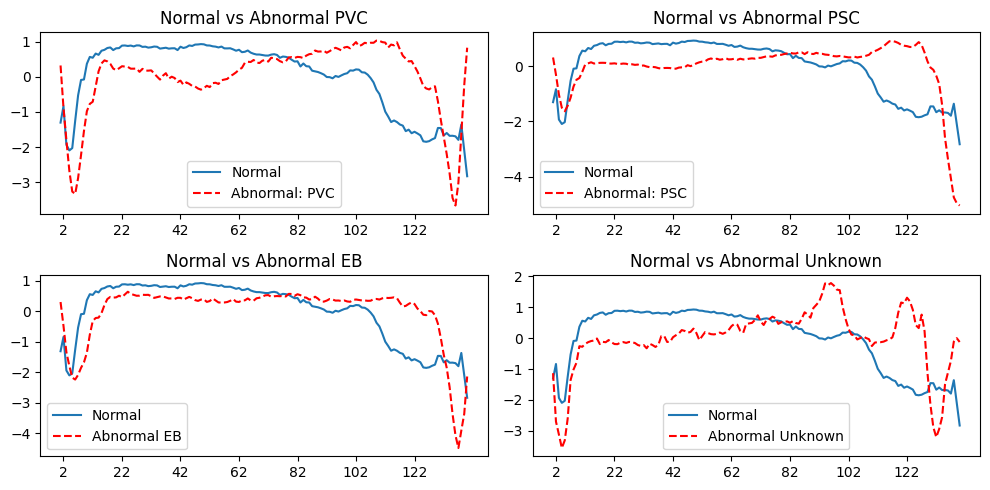

In [79]:
normal = train.iloc[0]
normal = normal.drop("label")
abnormal_pvc = train.iloc[1]
abnormal_pvc = abnormal_pvc.drop("label")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

axes[0, 0].plot(normal.index, normal, label="Normal")
axes[0, 0].plot(abnormal_pvc.index, abnormal_pvc, color="red", linestyle="dashed", label="Abnormal: PVC")
axes[0, 0].legend()
axes[0, 0].set_xticks(np.arange(1, 140, 20))
axes[0, 0].set_title("Normal vs Abnormal PVC")

abnormal_psc = train.iloc[18]
abnormal_psc = abnormal_psc.drop("label")

axes[0, 1].plot(normal.index, normal, label="Normal")
axes[0, 1].plot(abnormal_psc.index, abnormal_psc, color="red", linestyle="dashed", label="Abnormal: PSC")
axes[0, 1].legend()
axes[0, 1].set_xticks(np.arange(1, 140, 20))
axes[0, 1].set_title("Normal vs Abnormal PSC")

abnormal_eb = train.iloc[39]
abnormal_eb = abnormal_eb.drop("label")

axes[1, 0].plot(normal.index, normal, label="Normal")
axes[1, 0].plot(abnormal_eb.index, abnormal_eb, color="red", linestyle="dashed", label="Abnormal EB")
axes[1, 0].legend()
axes[1, 0].set_xticks(np.arange(1, 140, 20))
axes[1, 0].set_title("Normal vs Abnormal EB")

abnormal_unknown = train.iloc[159]
abnormal_unknown = abnormal_unknown.drop("label")

axes[1, 1].plot(normal.index, normal, label="Normal")
axes[1, 1].plot(abnormal_unknown.index, abnormal_unknown, color="red", linestyle="dashed", label="Abnormal Unknown")
axes[1, 1].legend()
axes[1, 1].set_xticks(np.arange(1, 140, 20))
axes[1, 1].set_title("Normal vs Abnormal Unknown")

plt.tight_layout()
plt.show()

### Traininig and validation dataset

In [93]:
#Pandas array to tf tensor
train_tf = tf.constant(train)
test_tf = tf.constant(test)

#Labels
train_labels = train_tf[:, 0]
test_labels = test_tf[:, 0]

#Divide based on categories
mask_train_1 = tf.equal(train_labels, 1)
mask_train_2 = tf.equal(train_labels, 2)
mask_train_3 = tf.equal(train_labels, 3)
mask_train_4 = tf.equal(train_labels, 4)
mask_train_5 = tf.equal(train_labels, 5)

mask_test_1 = tf.equal(test_labels, 1)
mask_test_2 = tf.equal(test_labels, 2)
mask_test_3 = tf.equal(test_labels, 3)
mask_test_4 = tf.equal(test_labels, 4)
mask_test_5 = tf.equal(test_labels, 5)

X_train_1 = tf.boolean_mask(train_tf[:, 1:], mask_train_1)
X_train_2 = tf.boolean_mask(train_tf[:, 1:], mask_train_2)
X_train_3 = tf.boolean_mask(train_tf[:, 1:], mask_train_3)
X_train_4 = tf.boolean_mask(train_tf[:, 1:], mask_train_4)
X_train_5 = tf.boolean_mask(train_tf[:, 1:], mask_train_5)

X_test_1 = tf.boolean_mask(test_tf[:, 1:], mask_test_1)
X_test_2 = tf.boolean_mask(test_tf[:, 1:], mask_test_2)
X_test_3 = tf.boolean_mask(test_tf[:, 1:], mask_test_3)
X_test_4 = tf.boolean_mask(test_tf[:, 1:], mask_test_4)
X_test_5 = tf.boolean_mask(test_tf[:, 1:], mask_test_5)

### Preprocessing data (Normalization)

In [120]:
#Use a MinMaxScaler and not a StandarScaler to preserve outlayers values. We need them because they will be useful for anomaly detection
scaler = MinMaxScaler()
X_train_1_s = tf.constant(scaler.fit_transform(X_train_1))
X_test_1_s = scaler.transform(X_test_1)
X_test_2_s = scaler.transform(X_test_2)
X_test_3_s = scaler.transform(X_test_3)
X_test_4_s = scaler.transform(X_test_4)
X_test_5_s = scaler.transform(X_test_5)

print("Originals min and max", tf.reduce_min(X_train_1).numpy(), tf.reduce_max(X_train_1).numpy())
print("Scaled min and max", tf.reduce_min(X_train_1_s).numpy(), tf.reduce_max(X_train_1_s).numpy())

Originals min and max -7.0904 4.9664
Scaled min and max 0.0 1.0000000000000002


### Creating the autoencoder

In [123]:
tf.random.set_seed(42)
dim_input = X_train_1_s[0].shape[0]

input = Input(shape=(dim_input, ))
encoder = Dense(64, activation="relu")(input)
encoder = Dense(32, activation="relu")(encoder)
encoder = Dense(16, activation="relu")(encoder)
encoder = Dense(8, activation="relu")(encoder)

decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(dim_input, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input, outputs=decoder)

autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 140)]             0         
                                                                 
 dense_41 (Dense)            (None, 64)                9024      
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dense_43 (Dense)            (None, 16)                528       
                                                                 
 dense_44 (Dense)            (None, 8)                 136       
                                                                 
 dense_45 (Dense)            (None, 16)                144       
                                                                 
 dense_46 (Dense)            (None, 140)               2380

In [124]:
autoencoder.compile(optimizer="adam", loss="mae")
history = autoencoder.fit(X_train_1_s, X_train_1_s, epochs=35, batch_size=300, validation_data=(X_test_1_s, X_test_1_s), shuffle=True)

Epoch 1/35
15/15 [==============================] - 10s 9ms/step - loss: 0.1242 - val_loss: 0.1195
Epoch 2/35
15/15 [==============================] - 0s 2ms/step - loss: 0.1129 - val_loss: 0.1042
Epoch 3/35
15/15 [==============================] - 0s 2ms/step - loss: 0.0951 - val_loss: 0.0853
Epoch 4/35
15/15 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0736
Epoch 5/35
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - val_loss: 0.0675
Epoch 6/35
15/15 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.0636
Epoch 7/35
15/15 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0606
Epoch 8/35
15/15 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0582
Epoch 9/35
15/15 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0565
Epoch 10/35
15/15 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0552
Epoch 11/35
15/15 

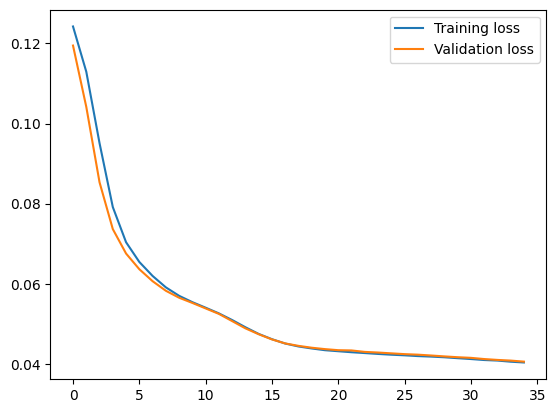

In [129]:
plt.figure()
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

In [138]:
print("Last training loss", history.history["loss"][-1])
print("Last validation loss", history.history["val_loss"][-1])
#We don't have overfitting

Last training loss 0.04033030942082405
Last validation loss 0.04054189845919609


### Clasification - How good is our model?

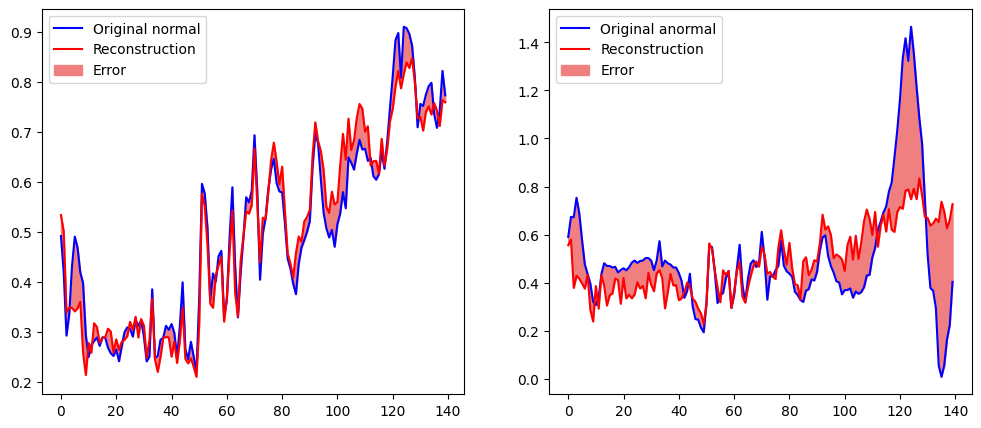

In [161]:
pred_normal = autoencoder.predict(X_test_1_s)
pred_anormal = autoencoder.predict(X_test_3_s)

idx = 5
fix, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(X_test_1_s[idx], "b")
axes[0].plot(pred_normal[idx], "r")
axes[0].fill_between(np.arange(140), pred_normal[idx], X_test_1_s[idx], color="lightcoral")
axes[0].legend(labels=["Original normal", "Reconstruction", "Error"])

axes[1].plot(X_test_3_s[idx], "b")
axes[1].plot(pred_anormal[idx], "r")
axes[1].fill_between(np.arange(140), pred_anormal[idx], X_test_3_s[idx], color="lightcoral")
axes[1].legend(labels=["Original anormal", "Reconstruction", "Error"])
plt.show()

### Distribution of reconstruction errors

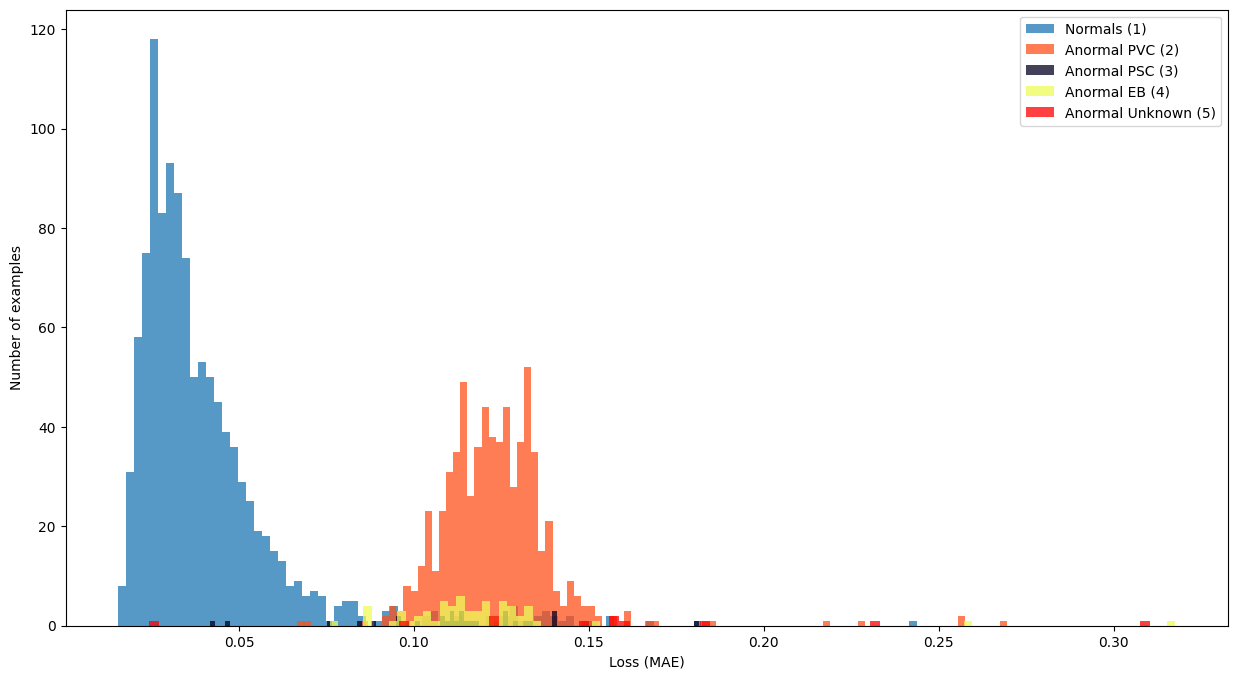

In [175]:
pred1 = autoencoder.predict(X_test_1_s)
pred2 = autoencoder.predict(X_test_2_s)
pred3 = autoencoder.predict(X_test_3_s)
pred4 = autoencoder.predict(X_test_4_s)
pred5 = autoencoder.predict(X_test_5_s)

loss1 = tf.keras.losses.mae(X_test_1_s, pred1)
loss2 = tf.keras.losses.mae(X_test_2_s, pred2)
loss3 = tf.keras.losses.mae(X_test_3_s, pred3)
loss4 = tf.keras.losses.mae(X_test_4_s, pred4)
loss5 = tf.keras.losses.mae(X_test_5_s, pred5)

plt.figure(figsize=(15, 8))
plt.hist(loss1, bins=100, alpha=0.75, label="Normals (1)")
plt.hist(loss2, bins=100, alpha=0.75, color="#ff521b", label="Anormal PVC (2)")
plt.hist(loss3, bins=100, alpha=0.75, color="#020122", label="Anormal PSC (3)")
plt.hist(loss4, bins=100, alpha=0.75, color="#eefc57", label="Anormal EB (4)")
plt.hist(loss5, bins=100, alpha=0.75, color="r", label="Anormal Unknown (5)")
plt.xlabel("Loss (MAE)")
plt.ylabel("Number of examples")
plt.legend(loc="upper right")

plt.show()